
Model training with training data generated on the fly
=======================================================

This example demonstrates how to generate training data on the fly during training.
Depending on the training situation, data generation speed may be fast enough to incorporate data on the fly for model training. 

Here, the example demonstrates single source model training similar as in [KHS19], but without simulating the time data (dataset2). Instead, the CSM is sampled according to a complex Wishart distribution.


## Build the dataset generator

At first, we manipulate the dataset config to only create single source examples on a smaller grid  of size $51 \times 51$

In [1]:
import os
import tensorflow as tf 
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # change tensorflow log level for doc purposes
from acoupipe.datasets.dataset2 import Dataset2, DEFAULT_GRID, DEFAULT_MICS

DEFAULT_GRID.increment = 1/50*DEFAULT_MICS.aperture

# training dataset
dataset = Dataset2(max_nsources = 1, f=1000, features=["sourcemap"])       

# build datasets for training and validation
training_dataset = dataset.get_tf_dataset(split="training",size=100000)
validation_dataset = dataset.get_tf_dataset(split="validation",size=10000)

2023-07-13 15:29:39.437431: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-13 15:29:39.585171: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-13 15:29:39.588281: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-13 15:29:39.588295: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

The TensorFlow dataset API can be used to build a data pipeline from the data generator. Here, batches with 32 source cases are used.

In [2]:

def yield_features_and_labels(data):   
    feature = data['sourcemap'][0]
    f_max = tf.reduce_max(feature)
    feature /= f_max
    label = tf.concat([data['loc'][:2],data['p2'][:,:,0,0]/f_max],axis=0)
    return (feature,label)

training_dataset = training_dataset.map(yield_features_and_labels).batch(16).repeat()
validation_dataset = validation_dataset.map(yield_features_and_labels).batch(16)


Now, one can build the ResNet50V2 model and use the data to fit the model. This may take several hours, depending on the computational infrastructure. 

In [3]:
# build model architecture
model = tf.keras.Sequential(
    tf.keras.applications.resnet_v2.ResNet50V2(
    include_top=False,
    weights=None,
    input_shape=(51,51,1),
    ))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(3, activation=None))

# compile and fit
model.compile(optimizer=tf.optimizers.Adam(1.5*10e-4),loss='mse')
model.fit(training_dataset,validation_data=validation_dataset, epochs=1,steps_per_epoch=1000)

1000/1000 [==============================] - 1271s 1s/step - loss: 0.2949 - val_loss: 0.0312


After successfully training, the model can be used for source characteristic prediction.

1/1 [==============================] - 0s 32ms/step


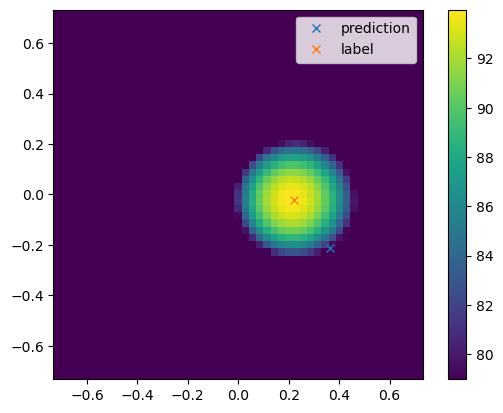

In [25]:
import matplotlib.pyplot as plt
from acoular import L_p

sourcemap, labels = next(iter(validation_dataset))
sourcemap = sourcemap[0].numpy()
labels = labels[0].numpy()
sourcemap /= sourcemap.max()
prediction = model.predict(sourcemap[np.newaxis])[0]

plt.figure()
plt.imshow(L_p(sourcemap.squeeze()).T,
            vmax=L_p(sourcemap.max()),
            vmin=L_p(sourcemap.max())-15,
            extent=DEFAULT_GRID.extend(),
            origin="lower")
plt.plot(prediction[0],prediction[1],'x',label="prediction")
plt.plot(labels[0],labels[1],'x',label="label")
plt.colorbar()
plt.legend()